# `sbi` on the classical drift-diffusion model using MNLE

## Motivation

It would be great to do fully Bayesian inference over the parameters of computational models in cognitive neuroscience. However, for many models of interest this is challenging, because Bayesian inference usually requires being able to efficiently evaluate the likelihood of the model, and this is often not possible. For example, when using the drift-diffusion model (DDM) for modeling decision making, only the most basic version of the DDM allows efficent access to the analytical likelihoods, i.e., for most variants Bayesian inference would be challenging. 

Mixed Neural Likelihood Estimation (MNLE) offers a solution to this problem. It enables simulation-based inference (SBI), i.e., Bayesian parameter inference that does not require access to the likelihood, but only access to data simulated from the model. Plus, MNLE is designed for simulation-based models with mixed data types as output, e.g., for models like the DDM, returning categorical choices and continuous reaction times. 

MNLE uses neural networks to parametrize a density estimator, and then trains the neural networks using data simulated from the model, such that the density estimator approximates the (intractable) likelihood of the model. After training, this ``neural likelihood'' can be used to perform Bayesian inference. In other words, given a model over which we want to do inference, but can't because we can't access its likelihood efficiently, we can just MNLE to  learn a synthetic likelihood with which can then do Bayesian inference. 

## SBI on the DDM

In the following we will use the implementation of MNLE and python toolbox [`sbi`](https://github.com/mackelab/sbi) to perform inference on the DDM.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sbi
import torch

import sbibm

# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## The DDM

We implemented an efficient version of the DDM as part of the benchmarking framework [`sbibm`](https://github.com/sbi-benchmark) and will use it here for generating training data for MNLE.

In this implementation the DDM has four parameters, the drift $v$, the decision boundary separation $a$, the initial offset/bias $w$, and the non-decision time $\tau$,  

In SBI we usually call parameters `theta` and simulated data `x`. The data that is observed experimentally is called `x_o`. 

Our goal is to obtain the posterior over parameters, given observed data, $p(\theta | x_o)$. To do this we generate training data $(\theta, x)$ to learn a neural likelihood with MNLE. 

In [2]:
# Loading DDM simulator and prior from sbibm framework.
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator()

In [3]:
# Load training data from disk.
N = 100000

with open("../data/ddm_training_data.p", "rb") as fh:
    theta, x, tho, xos = pickle.load(fh).values()

theta = theta[:N]
x = x[:N]

# The DDM simulator returns choices encoded as sign of the reaction times, decode:
rts = abs(x)
choices = torch.ones_like(x)
choices[x < 0] = 0
# Concatenate theta and choices for conditional flow training below.
theta_and_choices = torch.cat((theta, choices), dim=1)

For the DDM we can visualize the choice and reaction time data in one dimension by encoding the binary choice as the sign of the reaction time:

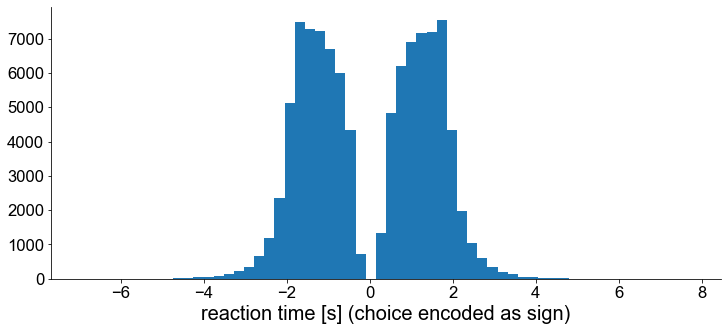

In [4]:
plt.figure(figsize=(12, 5))
plt.hist(x.numpy(), bins=60)
plt.xlabel("reaction time [s] (choice encoded as sign)");

## MNLE with `sbi`

To be applicable to models with mixed data types, MNLE actually learns two neural density estimators, one for the discrete part of the data (e.g., choices), and one for the continuous part (e.g., reation times). To choice density estimator estimates the density over choices given parameters. Crucially, to also learn the statistical dependencies between choices and reaction times, the reation time density estimator learns the density over reation times given parameters *and* choices. 

We use the `sbi` toolbox to train these two separate density estimators. To train custom density estimators with `sbi` one has to construct builder functions that take as first two arguments `theta` and `x` and return the corresponding neural net (`nn.Module`):

In [5]:
from functools import partial

import sbi

from sbi.analysis import pairplot
from sbi.inference import SNLE
from sbi.inference import likelihood_estimator_based_potential, MCMCPosterior
from mnle_utils import MNLE, build_choice_net

In [6]:
# This builds a standard NN to learn a Bernouli distribution to estimate choices.
choice_net_builder = partial(build_choice_net, 
                             z_score_theta=False, 
                             hidden_features=10, 
                             hidden_layers=2,
                            )

In [7]:
# For the reaction time estimator we use a neural spline flow as implemented in sbi:
# The builder takes theta as first argument and x as second.
def rt_flow_builder(batch_theta, batch_x, 
                  num_transforms=2, 
                  hidden_features=10, 
                  num_bins=5, 
                  tail_bound=10.0, 
                 **kwargs
                 ):
    # The flow builder takes x as first and theta as second.
    return sbi.neural_nets.flow.build_nsf(batch_x=batch_x, batch_y=batch_theta, 
                                          num_transforms=num_transforms, 
                                          hidden_features=hidden_features, 
                                          num_bins=num_bins, 
                                          tail_bound=tail_bound,
                                          **kwargs
                                         )

## Training

We train separate likelihood estimators for choices and reaction times.

In [8]:
num_hidden_layers = 1
num_hidden_units = 10

# for neural spline flow
use_log_rts = True
num_transforms = 2
num_bins = 5
tail_bound = 10.0

In [21]:
# First we train the choice net. 

# We create separate SNLE objects for every estimator.
trainer = SNLE(density_estimator=choice_net_builder, )
choice_estimator = trainer.append_simulations(theta, choices).train()

Neural network successfully converged after 218 epochs.


In [ ]:
rt_trainer = SNLE(density_estimator=rt_flow_builder)
rt_flow = rt_trainer.append_simulations(theta_and_choices, torch.log(rts) if use_log_rts else rts)
rt_flow = rt_trainer.train()

In [26]:
# Combine both trained density estimators into one MNLE
mnle = MNLE(choice_estimator, rt_flow, use_log_rts=True)

### Testing MNLE

We can test MNLE simply by generating synthetic data from it: Because it performs conditional density estimation, we can `sample()` the MNLE object given parameters, to generate synthetic DDM data:

In [29]:
M = 10000
x_syn = mnle.sample(M, tho)
x_syn_1d = x_syn[:, :1]
x_syn_1d[x_syn[:, 1:]==0, ] *= -1

Comparing the synthetic data to the corresponding data generated from the original DDM simulator we see that MNLE accurately emulates the DDM. This indicates, that it successfully learned the underlying likelihood!

Additionally, we can obtain the likelihoods of the reaction time and choices, given the underlying parameter, by calling `.log_prob()`.

In [30]:
# Construct test reaction times.
test_data = torch.linspace(-2, 2, 1000)
# Separate rts and choices.
test_rts = abs(test_data)
test_cs = torch.ones_like(test_data)
test_cs[test_data < 0] = 0

mnle_likelihoods = torch.tensor([mnle.log_prob(torch.hstack((r.reshape(-1, 1), c.reshape(-1, 1))), 
                                               tho)
                                 for r, c in zip(test_rts, test_cs)])

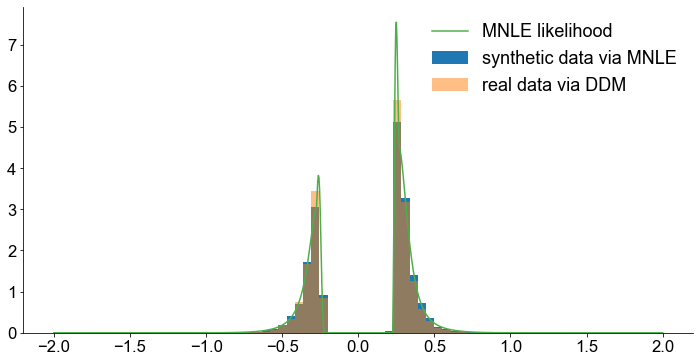

In [31]:
density = True

plt.figure(figsize=(12, 6))
_, bins, _ = plt.hist(x_syn_1d.numpy(), bins="auto", color="C0", 
                      label="synthetic data via MNLE", density=density);
# Plot real data on top,
plt.hist(xos.numpy(), bins=bins, alpha=0.5, color="C1", label="real data via DDM", density=density)
# and the MNLE likelihoods
plt.plot(test_data, mnle_likelihoods.exp(), label="MNLE likelihood", ls="-", c=colors[2]);
plt.legend();

In [32]:
# Save trained density estimator to disk.
with open("mnle.p", "wb") as fh:
    pickle.dump(dict(mnle=mnle), fh)

## Infer posterior samples with MCMC

In [38]:
# Observations from the benchmark come in 1D and encode choice with sign.
obs = 102
xo_signed = task.get_observation(obs)
x_o = torch.zeros(xo_signed.shape[1], 2)
theta_o = task.get_true_parameters(obs)
# Bring x into the form [rt, c]
x_o[:, 0] = abs(xo_signed[0, :])
x_o[(xo_signed > 0)[0, :], 1] = 1
x_o.shape

torch.Size([10, 2])

In [40]:
# Pass x_o and mnle object to build potential function.
potential_fn, parameter_transform = likelihood_estimator_based_potential(mnle, prior, x_o)
# Create MCMC-posterior object from potential function.
posterior = MCMCPosterior(potential_fn, proposal=prior, theta_transform=parameter_transform)

/home/janfb/qode/sbi/sbi/utils/sbiutils.py:204: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  respect to entire batch, i.e,. p(theta | X)."""


In [41]:
# Infer with MCMC
posterior_samples = posterior.sample((1000,), 
                                     method="slice_np", 
                                     num_chains=2, 
                                     warmup_steps=100,)

Generating samples: 100%|██████████| 500/500 [05:46<00:00,  1.44it/s]


## Visualize posteriors

In [22]:
from sbi.analysis import pairplot

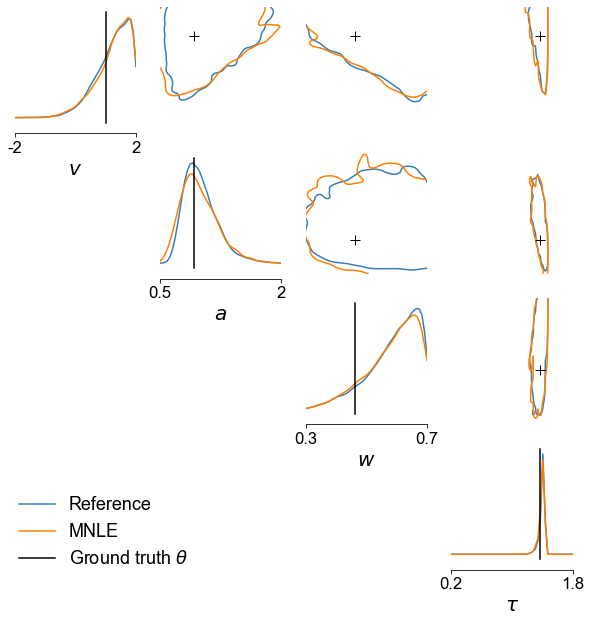

In [47]:
reference_posterior_samples = task.get_reference_posterior_samples(obs)
limits = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]]

fig, ax1 = pairplot([reference_posterior_samples, posterior_samples],
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=limits, 
         ticks=limits, 
         samples_colors=colors[:2], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_offdiag=dict(levels=[0.01], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"])

plt.sca(ax1[0, 0])
plt.legend(["Reference", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.9), 
           loc=2);

## Repeat inference with different observed data, without re-training MNLE

In [51]:
# Observations from the benchmark come in 1D and encode choice with sign.
obs = 202
xo_signed = task.get_observation(obs)
x_o = torch.zeros(xo_signed.shape[1], 2)
theta_o = task.get_true_parameters(obs)
# Bring x into the form [rt, c]
x_o[:, 0] = abs(xo_signed[0, :])
x_o[(xo_signed > 0)[0, :], 1] = 1
x_o.shape

torch.Size([100, 2])

In [52]:
# Pass x_o and mnle object to build potential function.
potential_fn, parameter_transform = likelihood_estimator_based_potential(mnle, prior, x_o)
# Create MCMC-posterior object from potential function.
posterior = MCMCPosterior(potential_fn, proposal=prior, theta_transform=parameter_transform)

In [53]:
# Infer with MCMC
posterior_samples = posterior.sample((1000,), 
                                     method="slice_np", 
                                     num_chains=2, 
                                     warmup_steps=100,)

Generating samples: 100%|██████████| 500/500 [09:54<00:00,  1.19s/it]


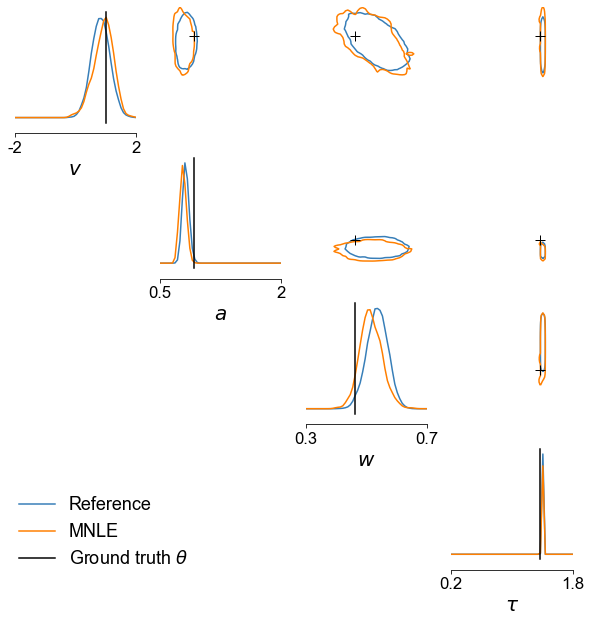

In [54]:
reference_posterior_samples = task.get_reference_posterior_samples(obs)

fig, ax1 = pairplot([reference_posterior_samples, posterior_samples],
         points=sbibm.get_task("ddm").get_true_parameters(obs), 
         limits=limits, 
         ticks=limits, 
         samples_colors=colors[:2], 
         diag="kde",
         upper="contour",
         kde_offdiag=dict(bw_method="scott", bins=50),
         contour_offdiag=dict(levels=[0.01], percentile=False),
         points_offdiag=dict(marker="+", markersize=10), 
         points_colors=["k"], 
         labels=[r"$v$", r"$a$", r"$w$", r"$\tau$"])

plt.sca(ax1[0, 0])
plt.legend(["Reference", "MNLE", r"Ground truth $\theta$"], 
           bbox_to_anchor=(-.1, -2.9), 
           loc=2);